# ReLU-based classifier
- ReLu activation, 4 layers, 100 neurons per layer

### Import modules

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [1]:
from __future__ import division
import sys
import os
sys.path.append('../../')
from modules.basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
NAME = '0_relu_baseline'

In [3]:
experiment = Experiment(NAME, 'helios_cuda', RESULTS_PATH)

In [4]:
!python ../../modules/data_import.py -d ../../data/ -s {experiment.seed}

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Converting to use_cartesian coordinates
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 31 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_sublea

## Training

### Import data

In [5]:
train_fy = FoldYielder(DATA_PATH/'train.hdf5')

### Options

In [6]:
n_models = 1
patience = 50
max_epochs = 200
ensemble_size = 10

bs = 256
objective = 'classification'
model_args = {'body':{'act':'relu', 'width':100, 'depth':4}}
opt_args = {'opt':'adam', 'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_fy)

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)
Model(model_builder)

Inputs:
31 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_met_pt']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead()
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=31, out_features=100, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_fea

### Determine LR

LR finder took 2.256s 


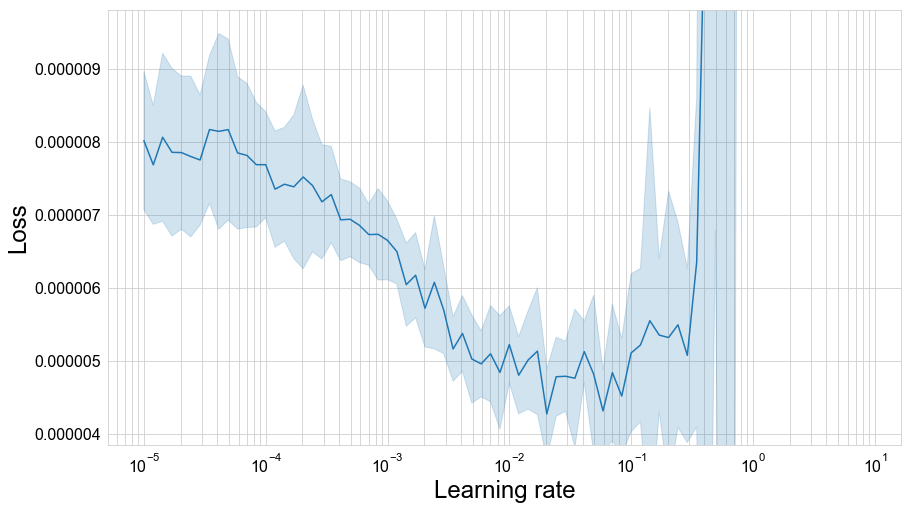

In [7]:
lr_finder = fold_lr_find(train_fy, model_builder, 256, lr_bounds=[1e-5,1e1])

### Train classifier

In [8]:
model_builder.set_lr(2e-3)
callback_partials = []
eval_metrics = {'AMS':AMS(n_total=250000, br=10, wgt_name='gen_weight_original')}


Training model 1 / 1, Val ID = 0


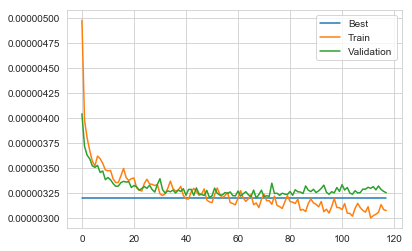

Early stopping after 118 epochs
Scores are: {'loss': 3.2020047910918947e-06, 'AMS': 3.8573184073652222}
Fold took 43.474s


______________________________________
Training finished
Cross-validation took 43.476s 


<Figure size 432x288 with 0 Axes>

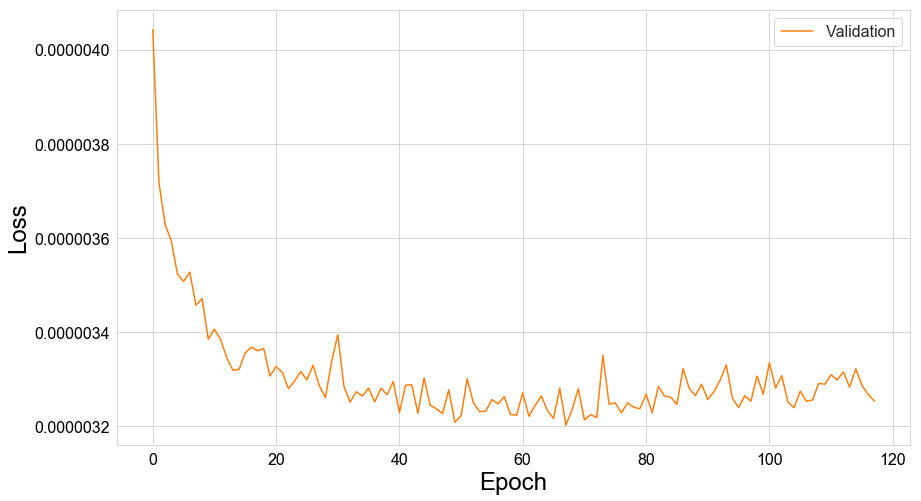

Mean loss = 3.2020047910918947e-06±0.0
Mean AMS = 3.8573184073652222±0.0
______________________________________



In [9]:
train_timer = timeit.default_timer()
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience)
train_time = timeit.default_timer()-train_timer
experiment['train_time'] = train_time

## Inference

### Construct ensemble

In [10]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [11]:
ensemble = Ensemble.from_results(results, ensemble_size, model_builder, metric='loss', higher_metric_better=False)

Choosing ensemble by loss


Model 0 is 0 with loss = 3.2020047910918947e-06


### Validation

#### Response on validation data

In [12]:
val_fy = FoldYielder(DATA_PATH/'val.hdf5')

In [13]:
val_timer = timeit.default_timer()
ensemble.predict(val_fy)
val_time = timeit.default_timer()-val_timer
experiment['val_time'] = val_time

Mean time per event = 7.9e-07±1e-08


In [14]:
val_df = val_fy.get_df()

50000 datapoints loaded


Mean cut at 0.938489556312561 corresponds to AMS of 3.3383846106425334
Maximum AMS for data is 3.3864018719232276 at cut of 0.9412785172462463


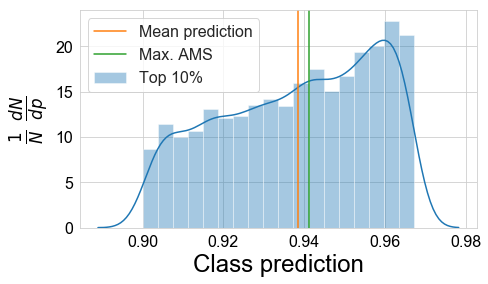

In [15]:
cut, experiment['val_ams_smooth'], experiment['val_ams_max'] = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

### Testing

#### Test scoring 

In [16]:
test_fy = FoldYielder(DATA_PATH/'test.hdf5')

In [17]:
test_timer = timeit.default_timer()
ensemble.predict(test_fy)
test_time = timeit.default_timer()-test_timer
experiment['test_time'] = test_time

Mean time per event = 2.8e-07±3e-08


In [18]:
experiment['test_public_ams_mean'], experiment['test_private_ams_mean'] = score_test_data_per_fold(test_fy, cut, pred_name='pred')

Mean Public:Private AMS: 3.43±0.07 : 3.46±0.02


In [19]:
experiment['test_public_ams'], experiment['test_private_ams'] = score_test_data(test_fy, cut, pred_name='pred')

Public:Private AMS: 3.4152910600122133 : 3.457117683092224


## Results 

In [20]:
experiment

Experiment:	0_relu_baseline
Machine:	helios_cuda
Device:	Nvidia GeForce GTX 1080 Ti GPU
train_time	43.782843346999925
val_time	0.04535975499993583
val_ams_smooth	3.3383846106425334
val_ams_max	3.3864018719232276
test_time	0.1655050790000132
test_public_ams_mean	(3.4252915287519867, 0.06698794119305782)
test_private_ams_mean	(3.458699202098417, 0.024287167847804977)
test_public_ams	3.4152910600122133
test_private_ams	3.457117683092224

In [21]:
experiment.save()